<a href="https://colab.research.google.com/github/Aryank47/machine_learning/blob/master/red_wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load the dataset
df = pd.read_csv('wine_data.csv')

In [3]:
# Display basic information about the dataset
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.00000

In [4]:
print("Most frequent wine quality:", df['quality'].mode()[0])
print("Lowest quality:", df['quality'].min())
print("Highest quality:", df['quality'].max())

Most frequent wine quality: 5
Lowest quality: 3
Highest quality: 8


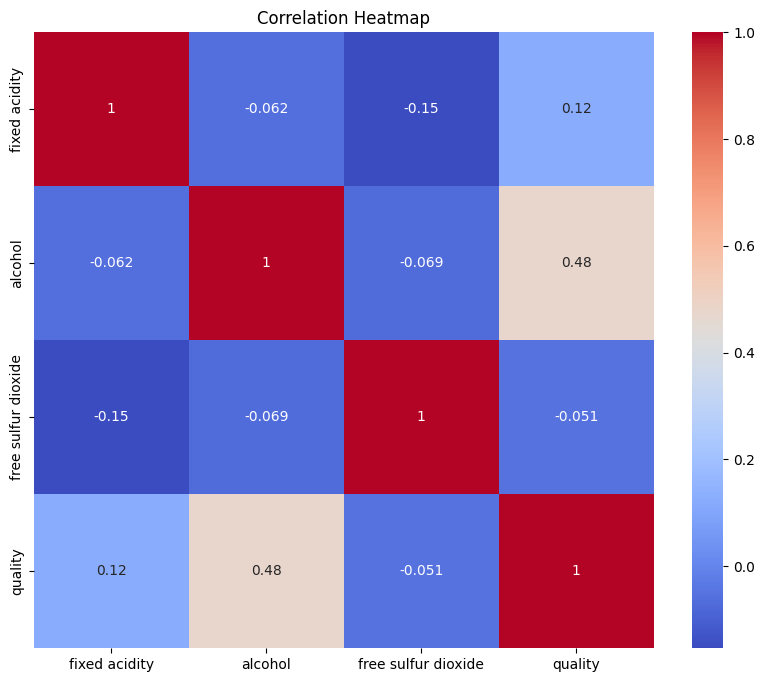

In [5]:
correlations = df[['fixed acidity', 'alcohol', 'free sulfur dioxide', 'quality']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [6]:
best_quality = df['quality'].max()
lowest_quality = df['quality'].min()

print(f"Average residual sugar for best quality wine ({best_quality}):",
      df[df['quality'] == best_quality]['residual sugar'].mean())
print(f"Average residual sugar for lowest quality wine ({lowest_quality}):",
      df[df['quality'] == lowest_quality]['residual sugar'].mean())

Average residual sugar for best quality wine (8): 2.5777777777777775
Average residual sugar for lowest quality wine (3): 2.6350000000000002


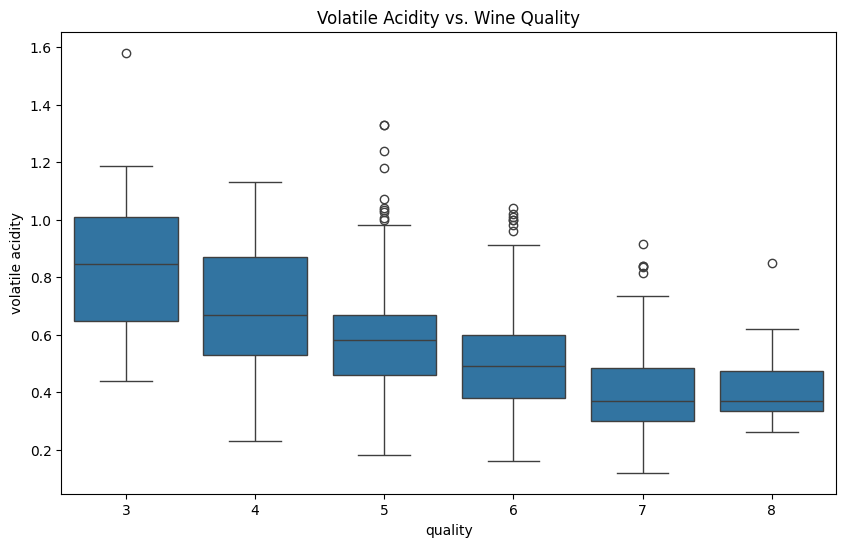

Correlation between volatile acidity and quality: -0.39


In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='volatile acidity', data=df)
plt.title('Volatile Acidity vs. Wine Quality')
plt.show()

correlation = df['volatile acidity'].corr(df['quality'])
print(f"Correlation between volatile acidity and quality: {correlation:.2f}")

In [8]:
# Prepare the data
X = df.drop('quality', axis=1)
y = df['quality']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# Function to plot model metrics
def plot_model_metrics(results, title):
    plt.figure(figsize=(12, 6))
    x = np.arange(len(results) // 2)
    width = 0.35

    plt.bar(x - width/2, [results[f'Train {m}'] for m in ['Accuracy', 'Precision', 'Recall', 'F1-score']],
            width, label='Train', alpha=0.8)
    plt.bar(x + width/2, [results[f'Test {m}'] for m in ['Accuracy', 'Precision', 'Recall', 'F1-score']],
            width, label='Test', alpha=0.8)

    plt.ylabel('Score')
    plt.title(f'{title} Metrics')
    plt.xticks(x, ['Accuracy', 'Precision', 'Recall', 'F1-score'])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to plot feature importance
def plot_feature_importance(model, X, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'best_estimator_'):
        importances = model.best_estimator_.feature_importances_
    else:
        print("Model doesn't have feature importances")
        return

    feature_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_imp = feature_imp.sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title(f'{title} - Feature Importance')
    plt.tight_layout()
    plt.show()

# Function to plot learning curve
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(f'{title} - Learning Curve')
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Function to plot prediction error
def plot_prediction_error(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Quality')
    plt.ylabel('Predicted Quality')
    plt.title(f'{title} - Prediction Error')
    plt.tight_layout()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, title):
    y_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} - ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Function to plot grid search results
def plot_grid_search_results(grid_result, title):
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(means)), means, yerr=stds, fmt='o')
    plt.title(f'{title} - Grid Search Results')
    plt.xlabel('Model Number')
    plt.ylabel('Mean CV Score')
    plt.tight_layout()
    plt.show()

    print(f"Best parms:", grid_result.best_params_)
    print(f"Best score: {grid_result.best_score_:.4f}")

# Function to evaluate and plot model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, title):
    if isinstance(model, GridSearchCV):
        model.fit(X_train, y_train)
        best_model = model.best_estimator_
    else:
        model.fit(X_train, y_train)
        best_model = model

    y_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)
    y_pred_proba = best_model.predict_proba(X_test)

    if title=="Decision Tree":
        plot_grid_search_results(model, title)
    if title=="Random Forest":
        plot_grid_search_results(model, title)
    if title=="XGBoost":
        plot_grid_search_results(model, title)
    metrics = {
        'Accuracy': (accuracy_score, {}),
        'Precision': (precision_score, {'average': 'weighted'}),
        'Recall': (recall_score, {'average': 'weighted'}),
        'F1-score': (f1_score, {'average': 'weighted'})
    }

    results = {}
    for metric_name, (metric_func, metric_kwargs) in metrics.items():
        train_score = metric_func(y_train, y_train_pred, **metric_kwargs)
        test_score = metric_func(y_test,y_pred, **metric_kwargs)
        results[f'Train {metric_name}'] = train_score
        results[f'Test {metric_name}'] = test_score
        print(f"{metric_name} - Train: {train_score:.4f}, Test: {test_score:.4f}")

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{title} Accuracy: {accuracy:.4f}")


    plot_feature_importance(best_model, X, title)
    if title=="XGBoost":
        plot_learning_curve(best_model, X, y-3, title)
    else:
        plot_learning_curve(best_model, X, y, title)
    plot_prediction_error(y_test, y_pred, title)
    plot_confusion_matrix(y_test, y_pred, title)
    plot_roc_curve(y_test, y_pred_proba, title)

    return results

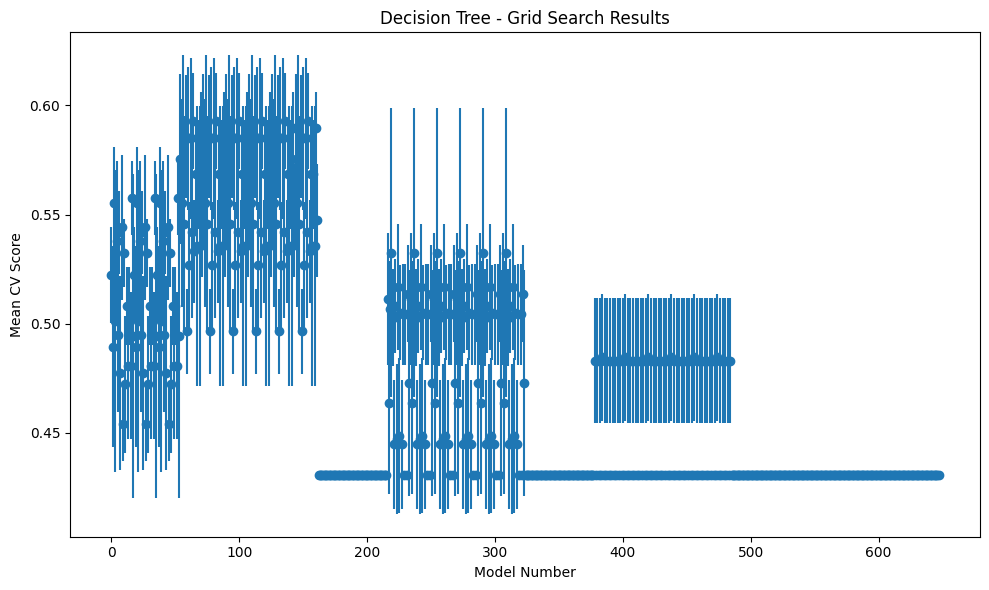

Best parms: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Best score: 0.5927
Accuracy - Train: 0.6192, Test: 0.5375
Precision - Train: 0.6057, Test: 0.5169
Recall - Train: 0.6192, Test: 0.5375
F1-score - Train: 0.6027, Test: 0.5236
Decision Tree Accuracy: 0.5375


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


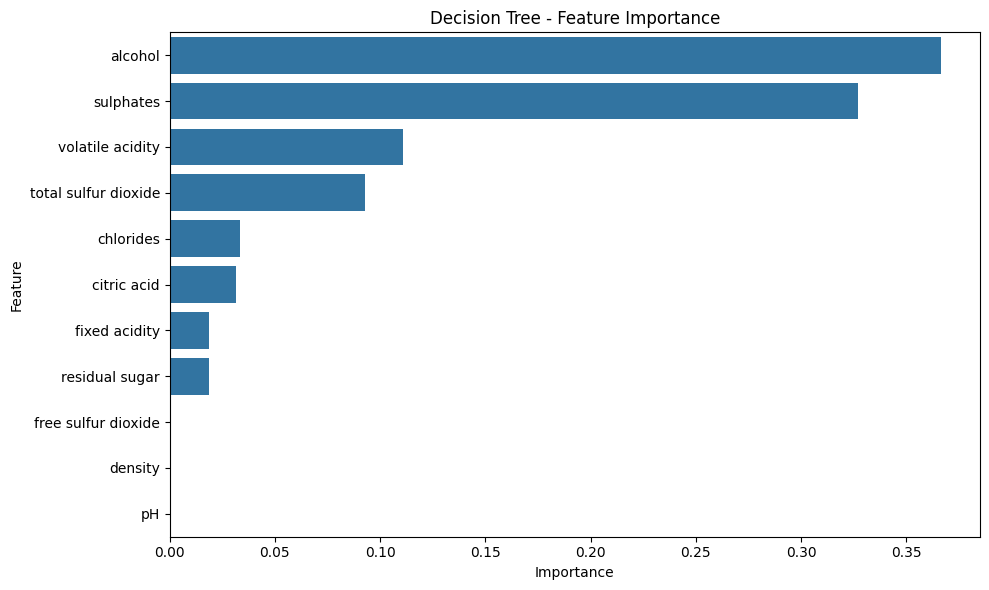

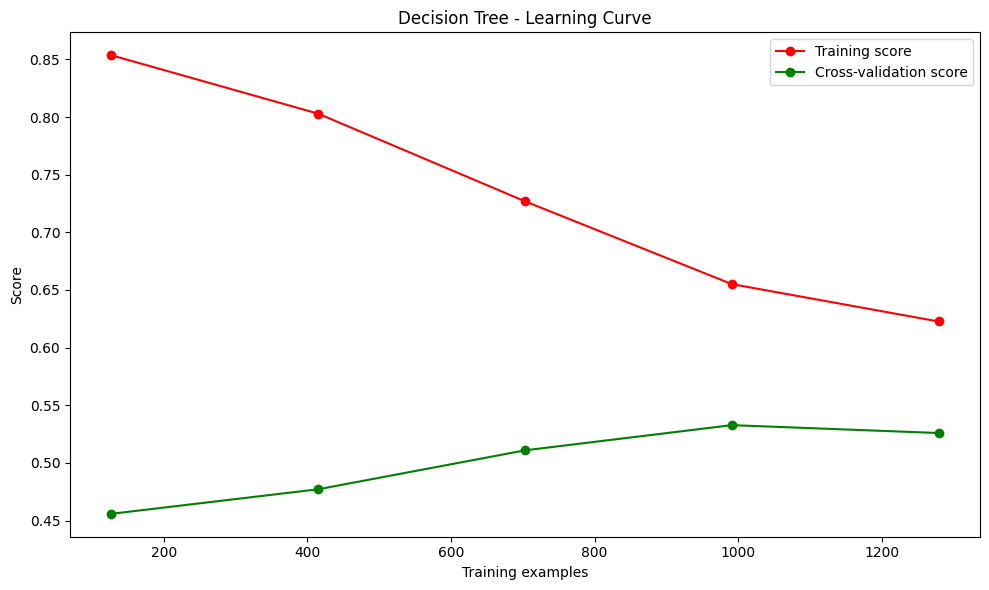

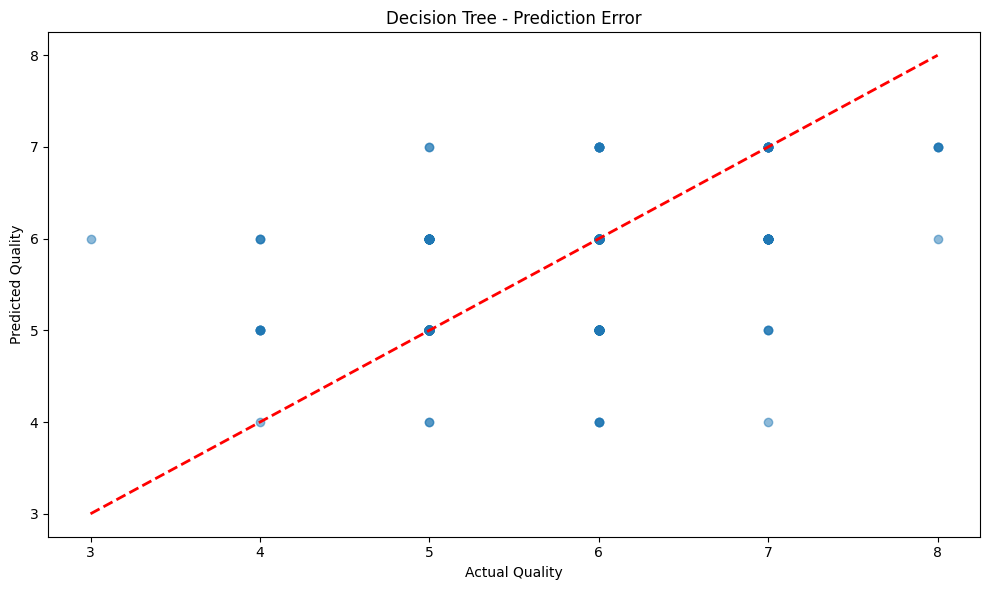

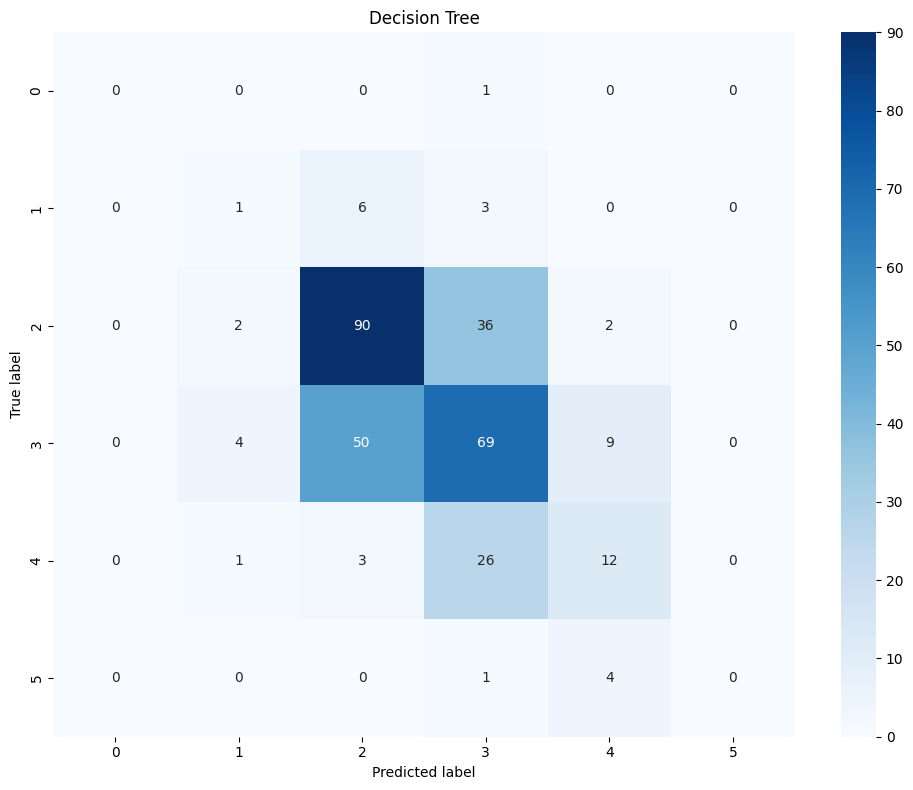

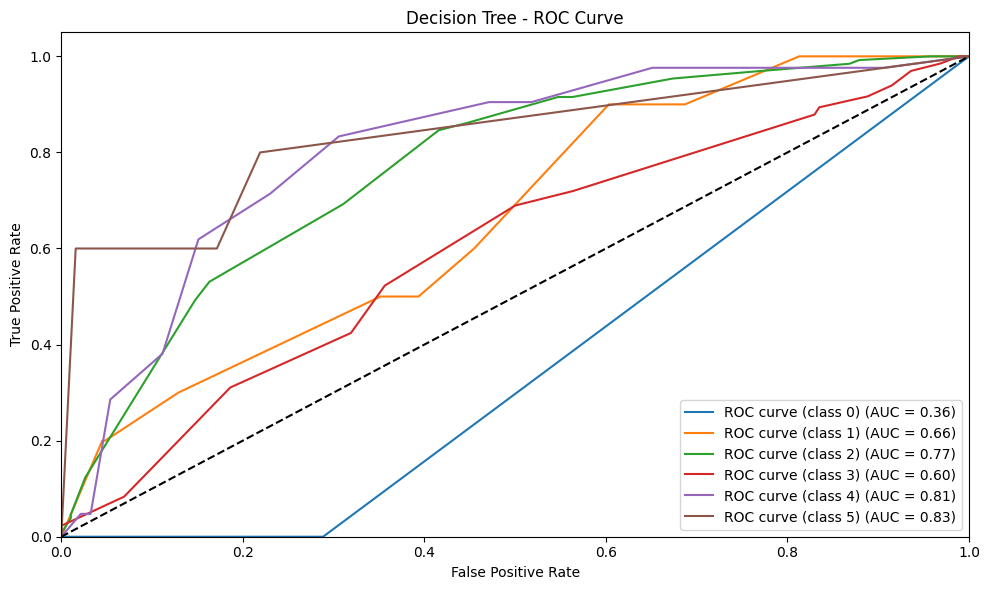

In [10]:
# Decision Tree with Grid Search
dt_params = {
    'criterion': ['gini', 'entropy','log_loss'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2','auto'],
    'ccp_alpha': [0.01,0.05,0.1,0.5]
}

dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, n_jobs=-1)
dt_results=evaluate_model(dt, X_train, X_test, y_train, y_test, "Decision Tree")

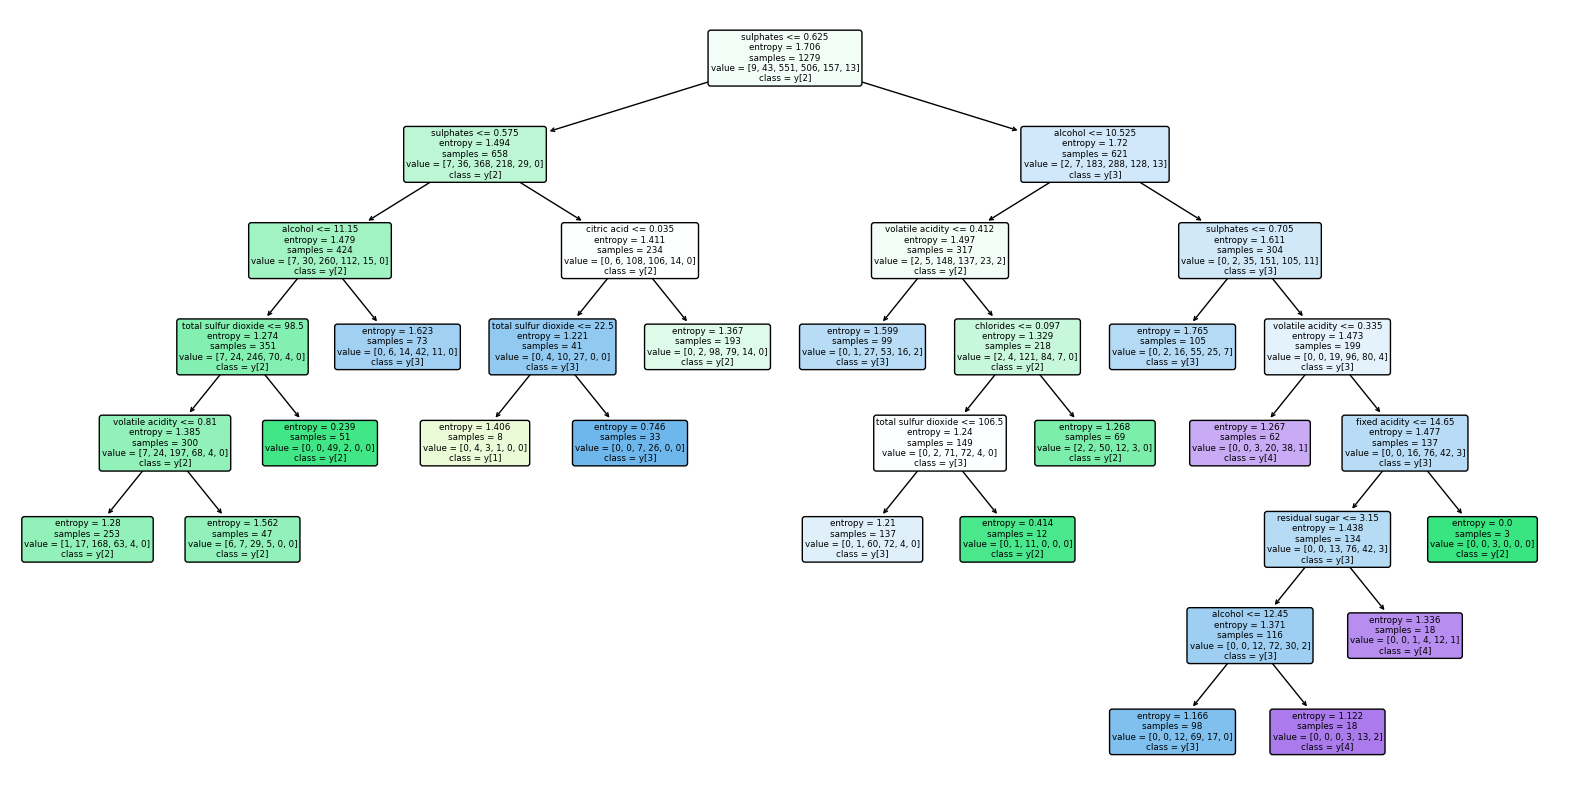

In [11]:
plt.figure(figsize=(20,10))
plot_tree(dt.best_estimator_, feature_names=X.columns, class_names=True, filled=True, rounded=True)
plt.show()

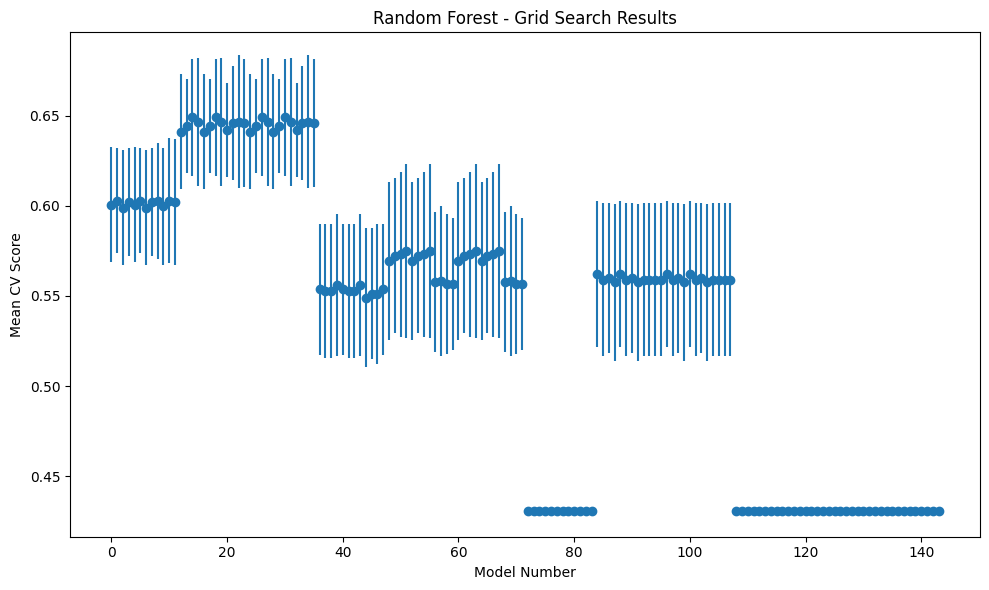

Best parms: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 300}
Best score: 0.6490
Accuracy - Train: 0.7193, Test: 0.5844
Precision - Train: 0.6909, Test: 0.5491
Recall - Train: 0.7193, Test: 0.5844
F1-score - Train: 0.6939, Test: 0.5503
Random Forest Accuracy: 0.5844


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


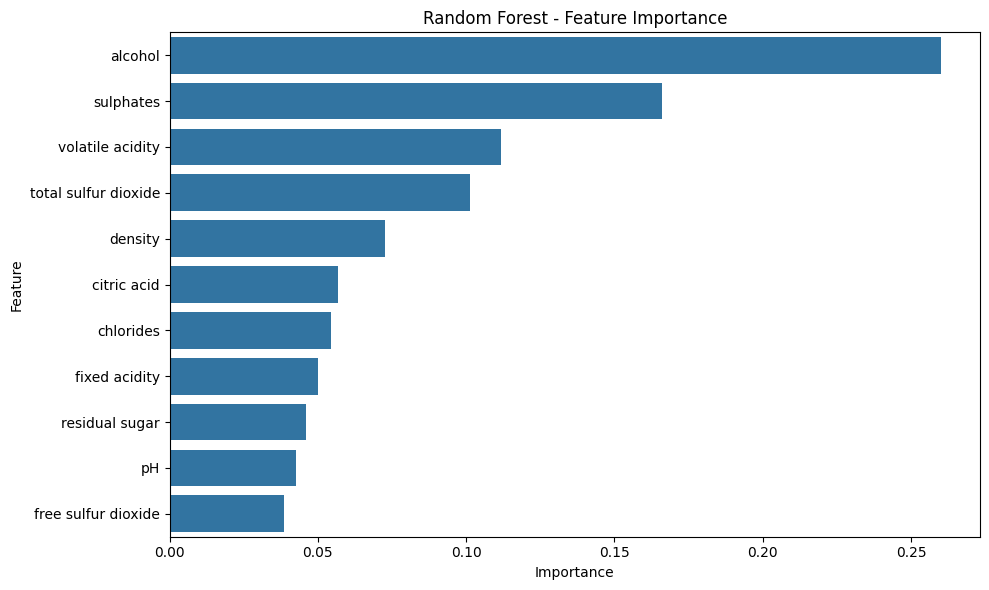

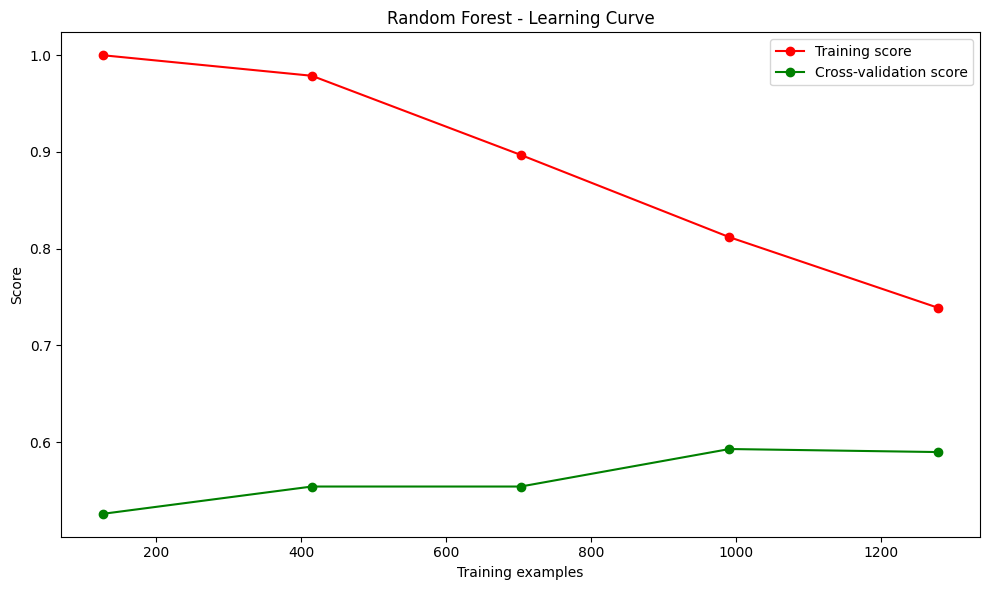

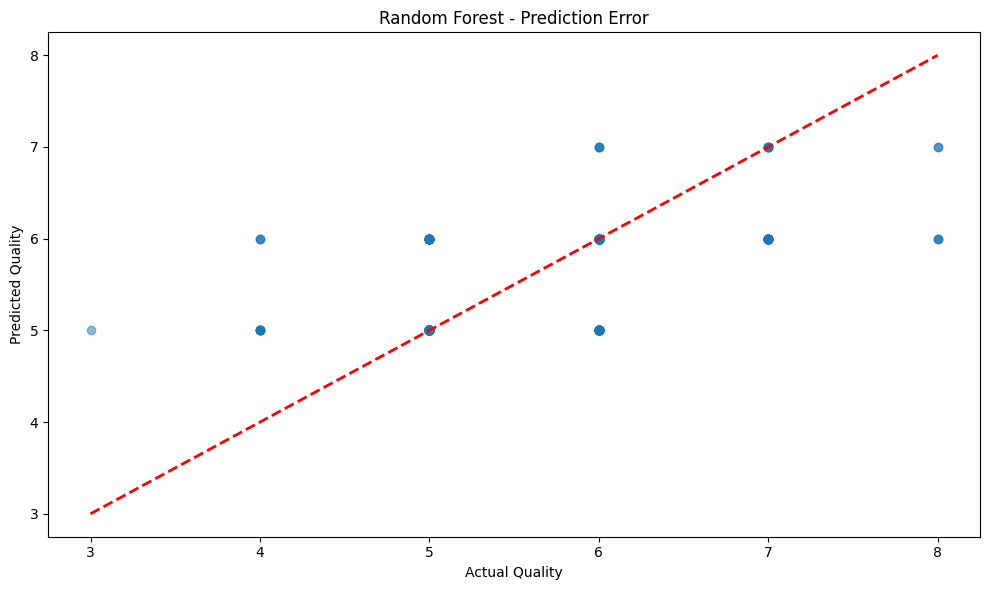

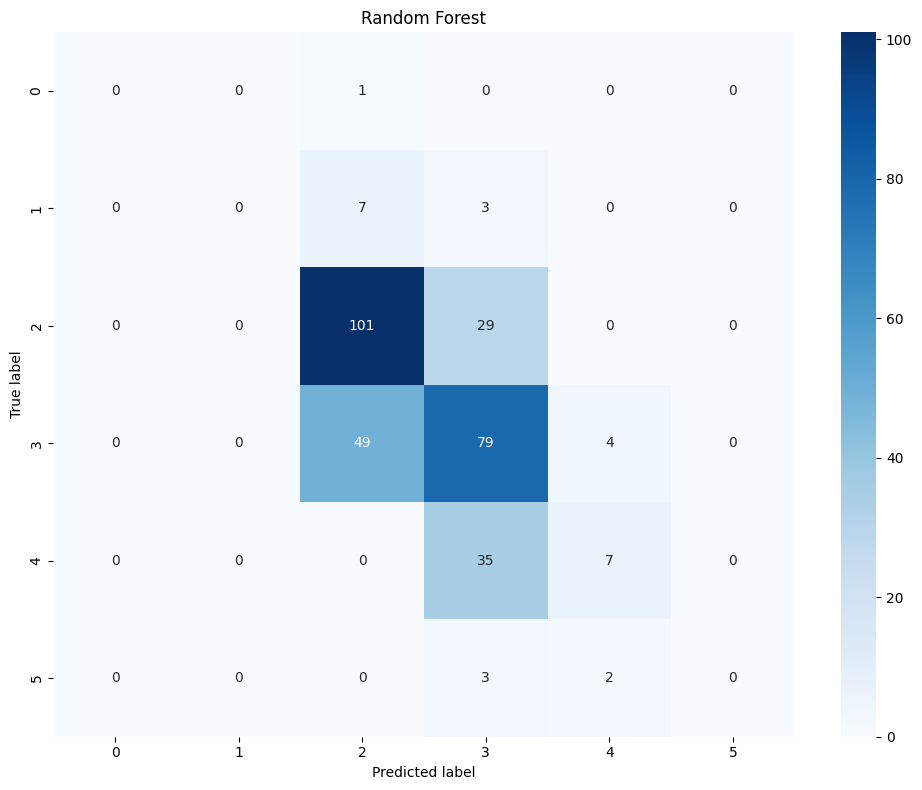

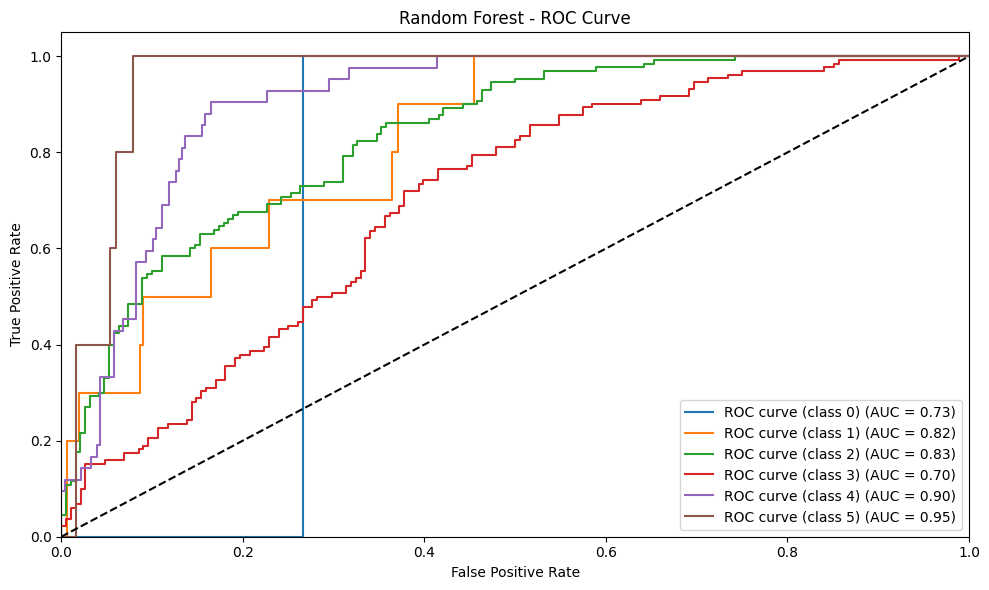

In [12]:
# Random Forest with Grid Search
rf_params = {
    'n_estimators': [100, 200, 300,500],
    'criterion': ['gini', 'entropy','log_loss'],
    'max_features': ['sqrt', 'log2',None],
    'ccp_alpha': [0.01,0.05, 0.1, 0.5]
}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_jobs=-1)
rf_results=evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

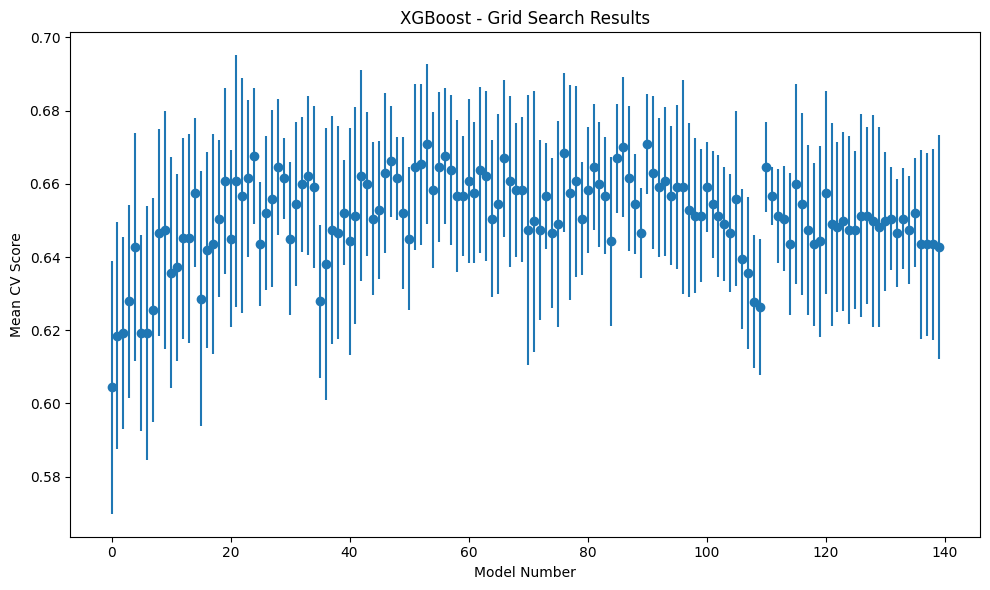

Best parms: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}
Best score: 0.6709
Accuracy - Train: 1.0000, Test: 0.6844
Precision - Train: 1.0000, Test: 0.6613
Recall - Train: 1.0000, Test: 0.6844
F1-score - Train: 1.0000, Test: 0.6703
XGBoost Accuracy: 0.6844


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


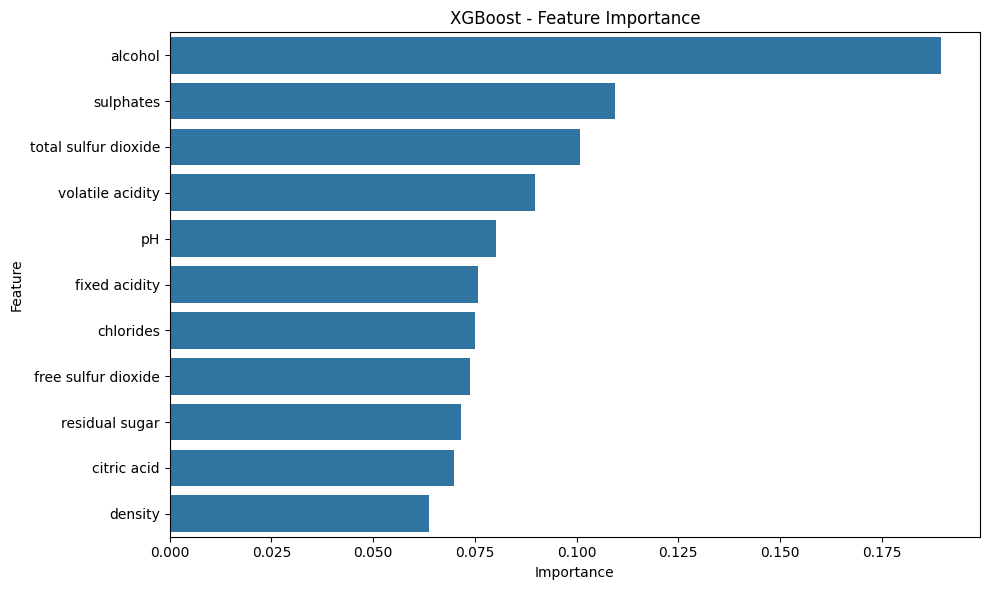

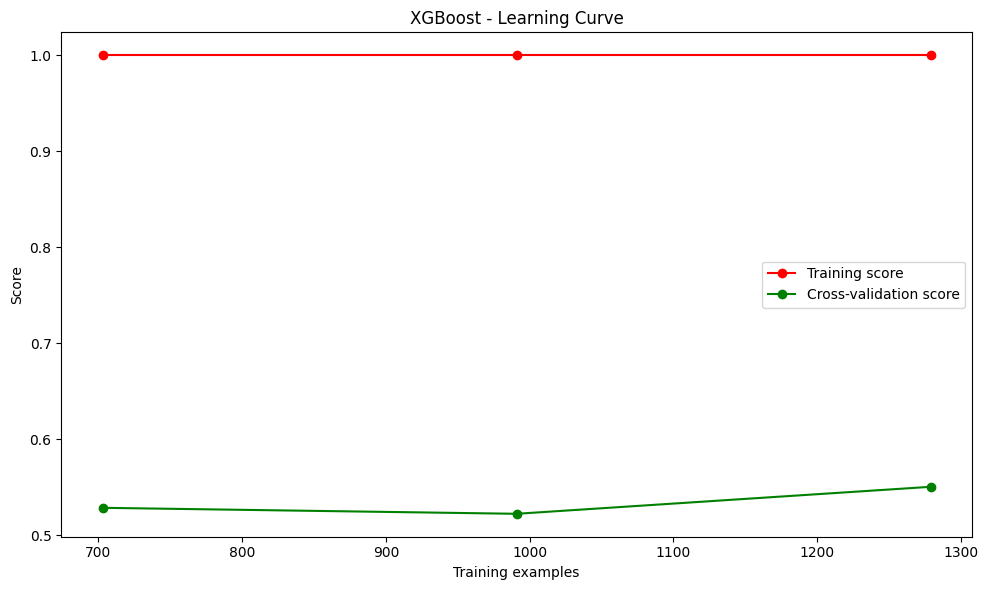

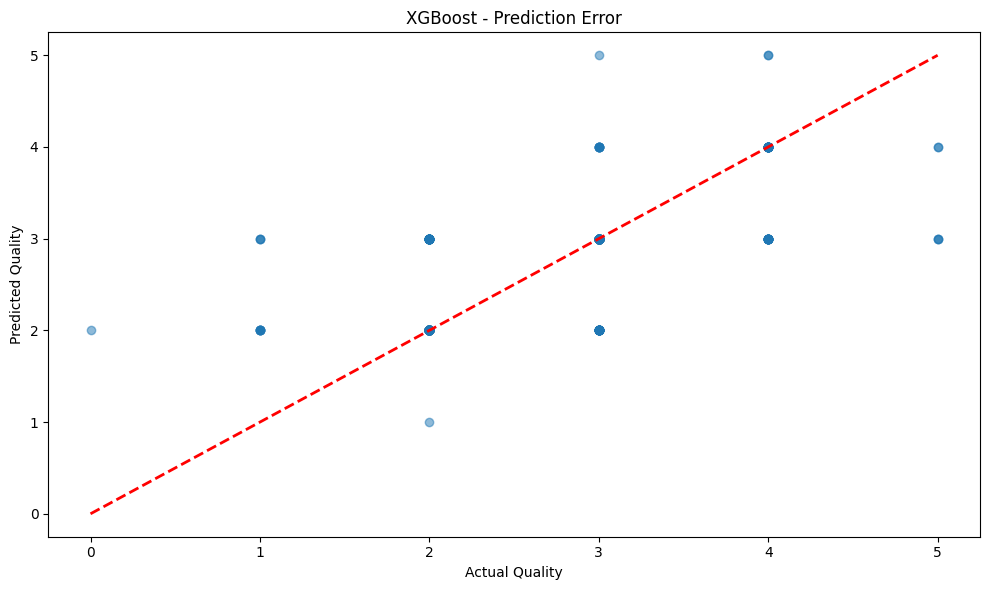

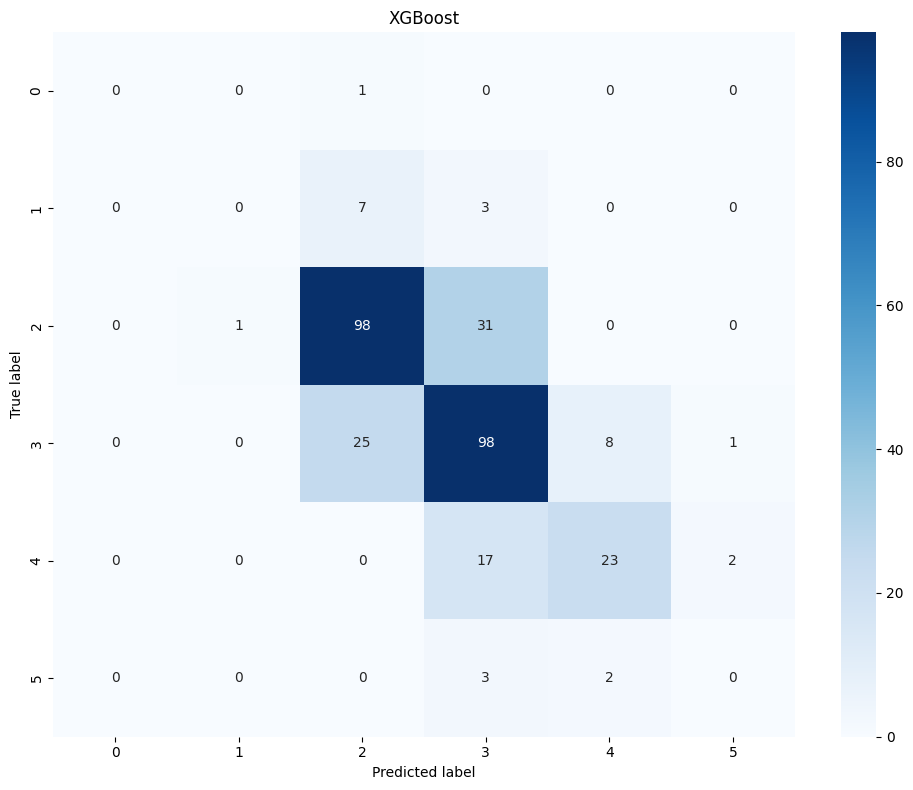

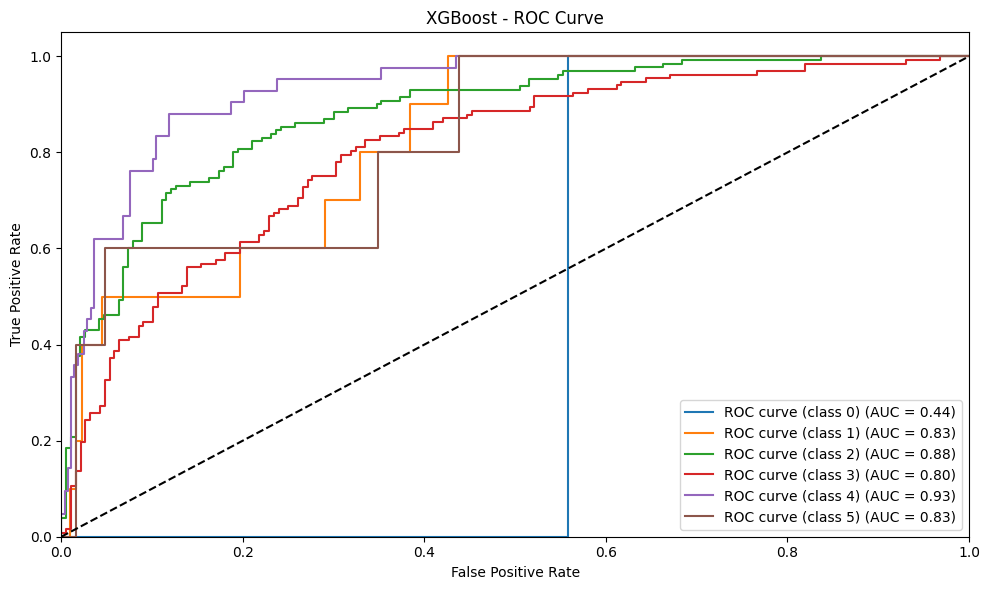

In [13]:
# XGBoost with Grid Search
xgb_params = {
    'n_estimators': [100, 200, 300,500,1000],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

# Adjust target labels to start from 0
y_train_adjusted = y_train - 3
y_test_adjusted = y_test - 3
xgb = GridSearchCV(XGBClassifier(random_state=42), xgb_params, cv=5, n_jobs=-1)
xgb_results=evaluate_model(xgb, X_train, X_test, y_train_adjusted, y_test_adjusted, "XGBoost")

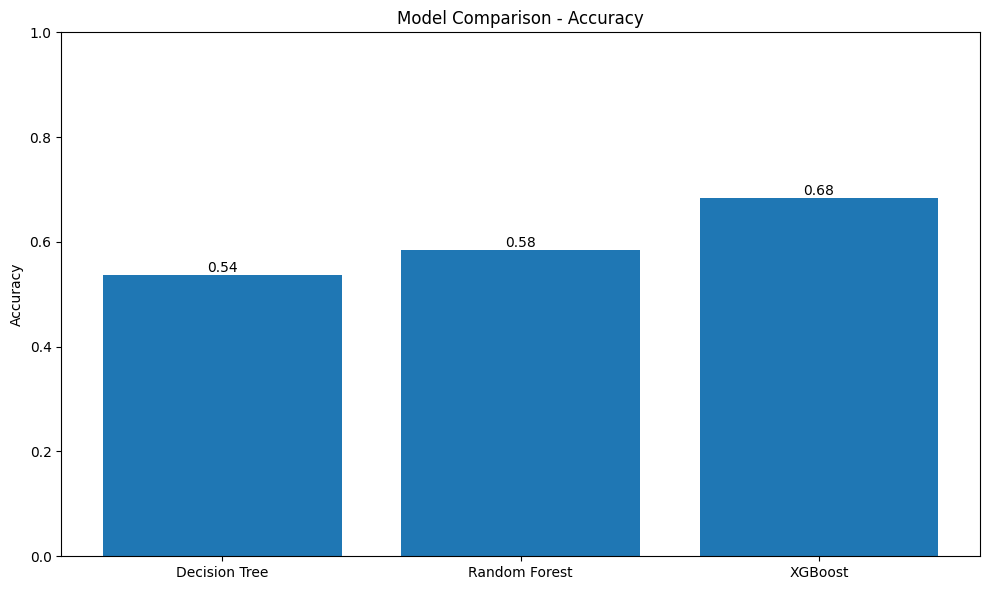

In [14]:
# Compare final models
models = [dt, rf, xgb]
model_names = ['Decision Tree', 'Random Forest', 'XGBoost']

accuracies = []
for index,model in enumerate(models):
    y_pred = model.predict(X_test)
    if index==2:
        accuracies.append(accuracy_score(y_test_adjusted, y_pred))
    else:
        accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

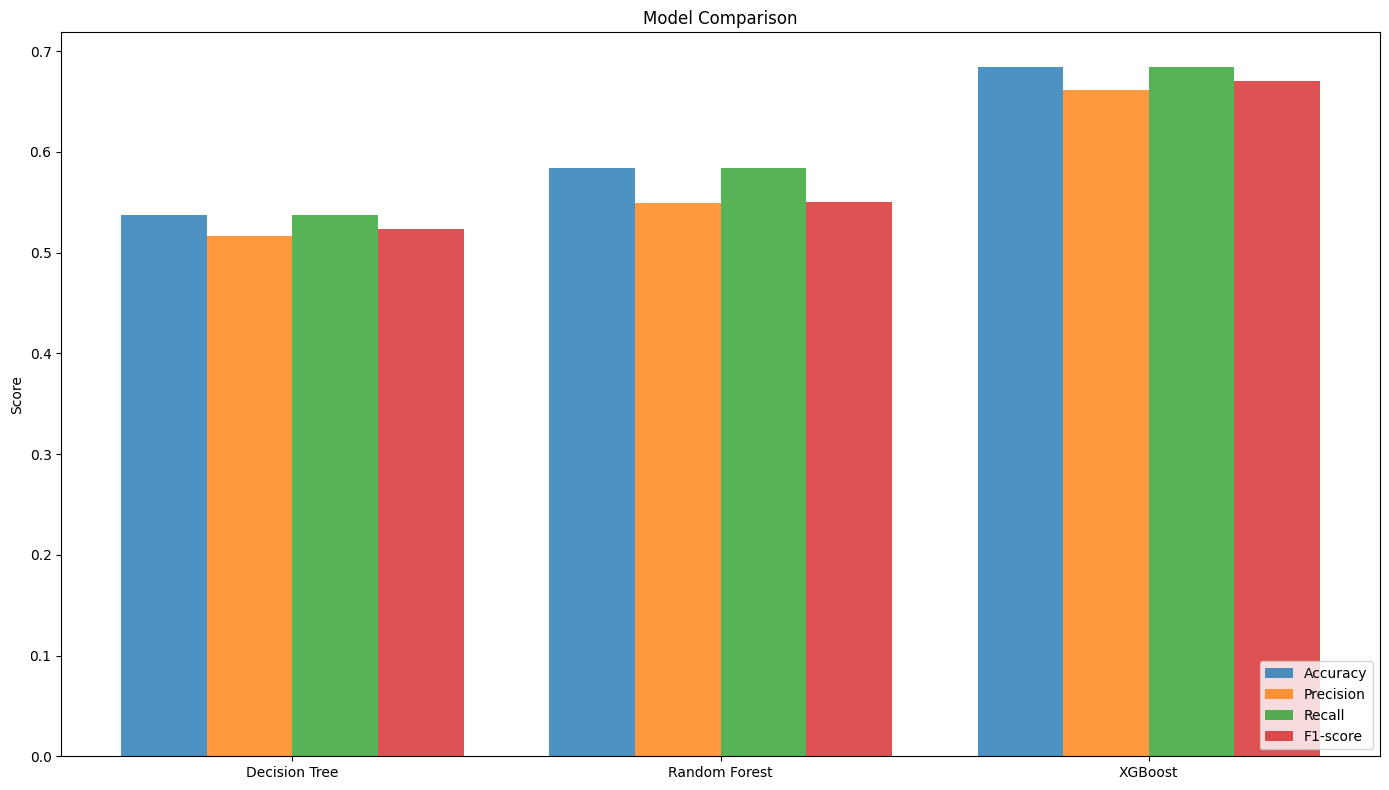

In [15]:
# Compare final models
models = [dt.best_estimator_, rf.best_estimator_, xgb.best_estimator_]
model_names = ['Decision Tree', 'Random Forest', 'XGBoost']

plt.figure(figsize=(14, 8))
x = np.arange(len(model_names))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
for i, metric in enumerate(metrics):
    plt.bar(x + i*width, [results[f'Test {metric}'] for results in [dt_results, rf_results, xgb_results]],
            width, label=metric, alpha=0.8)

plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x + width*1.5, model_names)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()